## Project 3 - City Segmentation - Train
This is training source with UNET and cross entropy. With epoch = 80 still cannot produce good result

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nproc

8


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
mask_path = f"datasets_used/train/masks/0016E5_06330.png"
m = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
#6  8  9 11]
replace_val = {6: 5, 8: 6, 9: 7, 11: 8}
for key, val in replace_val.items():
    m[m == key] = val

In [ ]:
np.unique(m)
cv2.imwrite('tes.png', m)

True

In [ ]:
n= cv2.imread('tes.png',cv2.IMREAD_GRAYSCALE)

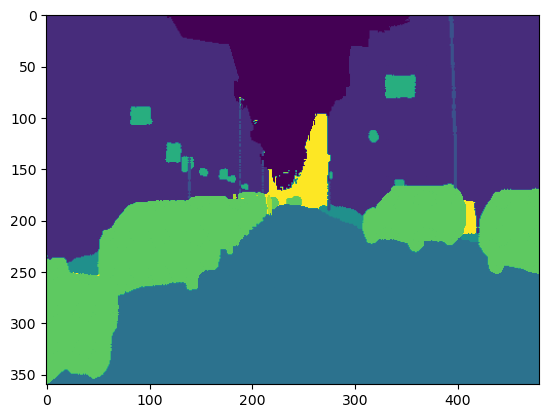

In [ ]:
plt.imshow(n)

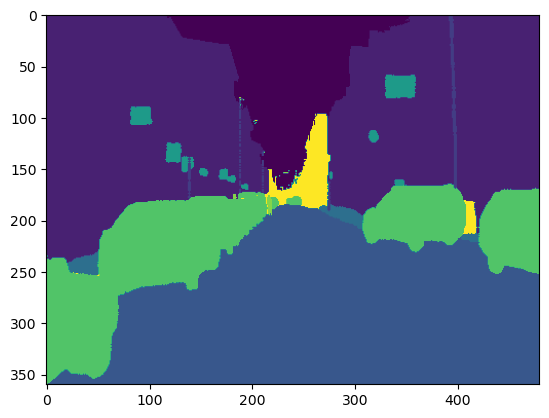

In [ ]:
mask_path = f"datasets_used/train/masks/0016E5_06330.png"
m = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
plt.imshow(m)

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms, datasets
import numpy as np
import os

class CityscapesDataset(Dataset):

    def __init__(self, root, split=None, from_start=True, transform=None, eval=False ):
        super().__init__()
        self.root = root
        self.split = split
        self.transform = transform
        self.eval = eval
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root,"images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root,"masks"))))
        #self.split_imgs = []
        #self.split_masks = []

        if split is None :
          pass
        elif from_start is True :
          self.imgs = self.imgs[:int(len(self.imgs)*split)]
          self.masks = self.masks[:int(len(self.masks)*split)]
        elif from_start is False :
          self.imgs = self.imgs[int(len(self.imgs)*split):]
          self.masks = self.masks[int(len(self.masks)*split):]

        print(len(self.masks))
        print(self.imgs[0:2])

    def __len__(self):
        length = len(self.imgs)
        return length


    def __getitem__(self, idx):
        file_img = os.path.join(f"{self.root}/images",self.imgs[idx])
        file_mask = os.path.join(f"{self.root}/masks",self.masks[idx])

        image = Image.open(file_img)
        masks = Image.open(file_mask)

        if self.transform is not None:
            image = self.transform(image)
            masks = self.transform(masks)

        image = transforms.ToTensor()(image)
        masks = np.array(masks)
        masks = torch.from_numpy(masks)

        #masks = masks/255
        masks.dtype
        #masks = masks.type(torch.LongTensor)
        masks = masks.type(torch.LongTensor)
        if self.eval:
            return image, masks, self.imgs[idx]
        else:
            return image, masks




In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class UNET(nn.Module):

    def __init__(self, in_channels=3, classes=1):
        super(UNET, self).__init__()
        self.layers = [in_channels, 64, 128, 256, 512, 1024]

        self.double_conv_downs = nn.ModuleList(
            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])

        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])

        self.double_conv_ups = nn.ModuleList(
        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)


    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv

    def forward(self, x):
        # down layers
        concat_layers = []

        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)

        concat_layers = concat_layers[::-1]

        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])

            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)

        x = self.final_conv(x)

        return x

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, utils, transforms
from PIL import Image
from tqdm import tqdm
import numpy as np

#root, split=None, from_start=True, transform=None, eval=False ):

def get_cityscapes_data(
    split,
    from_start=True,
    root_dir=f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/datasets_used",  #'datasets_used',
    transforms=None,
    batch_size=8,
    eval=False,
    shuffle=True,
    pin_memory=True,

):
    data = CityscapesDataset(
        root=root_dir, split=split, from_start=from_start, transform=transforms, eval=eval)

    data_loaded = torch.utils.data.DataLoader(
        data, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)

    return data_loaded

# Functions to save predictions as images
def save_as_images(tensor_pred, folder, image_name):
    tensor_pred = transforms.ToPILImage()(tensor_pred.byte())
    filename = f"{folder}\{image_name}.png"
    tensor_pred.save(filename)

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
#from utils import *
#from model import UNET

if torch.cuda.is_available():
    DEVICE = 'cuda:0'
    print('Running on the GPU')
else:
    DEVICE = "cpu"
    print('Running on the CPU')

MODEL_PATH = f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/ckpt_save/unet.pth" #'ckpt_save/unet'
LOAD_MODEL = False
ROOT_DIR = f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/datasets_used" #'datasets_used'
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 8
LEARNING_RATE = 0.0005
EPOCHS = 50

def train_function(data, model, optimizer, loss_fn, device):
    print('Entering into train function')
    loss_values = []
    data = tqdm(data)
    for index, batch in enumerate(data):
        X, y = batch
        X, y = X.to(device), y.to(device)
        preds = model(X)
        #pred_labels = torch.argmax(preds, dim=1)
        #print(f"preds shape {preds.shape} with {preds.dtype} {pred_labels.shape}")
        #print(f"y shape {y.shape} with {y.dtype}")
        #print(pred_labels)
        #print(y)

        loss = loss_fn(preds, y)
        #loss = loss_fn(pred_labels, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

def val_function(data, model, loss_fn, device):
    model.eval()
    print('Entering into validation function')
    loss_values = []
    data = tqdm(data)
    for index, batch in enumerate(data):
        with torch.no_grad():
            X, y = batch
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = loss_fn(preds, y)

    return loss.item()

def program_main():
    global epoch
    epoch = 0 # epoch is initially assigned to 0. If LOAD_MODEL is true then
              # epoch is set to the last value + 1.
    LOSS_TRAIN = [] # Defining a list to store loss values after every epoch
    LOSS_VAL = []

    transform = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.NEAREST),
    ])


    train_set = get_cityscapes_data(
        split=0.8,
        from_start=True,
        root_dir=f"{ROOT_DIR}/train",
        transforms=transform,
        batch_size=BATCH_SIZE,
    )
    val_set = get_cityscapes_data(
        split=0.8,
        from_start=False,
        root_dir=f"{ROOT_DIR}/train",
        transforms=transform,
        batch_size=BATCH_SIZE,
    )


    print('Data Loaded Successfully!')

    # Defining the model, optimizer and loss function
    unet = UNET(in_channels=3, classes=12).to(DEVICE).train()
    optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
    loss_function = nn.CrossEntropyLoss(ignore_index=255)

    # Loading a previous stored model from MODEL_PATH variable
    if LOAD_MODEL == True:
        checkpoint = torch.load(MODEL_PATH)
        unet.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        epoch = checkpoint['epoch']+1
        LOSS_TRAIN = checkpoint['loss_train']
        LOSS_VAL = checkpoint['loss_validation']
        print("Model successfully loaded!")

    #Training the model for every epoch.
    for e in range(epoch, EPOCHS):
        print(f'Epoch: {e}')
        loss_train = train_function(train_set, unet, optimizer, loss_function, DEVICE)
        print(f"Loss Train : {loss_train}")
        LOSS_TRAIN.append(loss_train)
        loss_val = val_function(val_set, unet, loss_function, DEVICE)
        LOSS_VAL.append(loss_val)
        print(f"Loss Validation : {loss_val}")

        torch.save({
            'model_state_dict': unet.state_dict(),
            'optim_state_dict': optimizer.state_dict(),
            'epoch': e,
            'loss_train': LOSS_TRAIN,
            'loss_validation': LOSS_VAL
        }, MODEL_PATH)
        print("Epoch completed and model successfully saved!")

Running on the GPU


In [ ]:
program_main()

293
['0001TP_006690.png', '0001TP_006720.png']
74
['0016E5_06210.png', '0016E5_06240.png']
Data Loaded Successfully!
Epoch: 0
Entering into train function


100%|██████████| 37/37 [01:30<00:00,  2.45s/it]


Loss Train : 0.8876737356185913
Entering into validation function


100%|██████████| 10/10 [00:20<00:00,  2.03s/it]


Loss Validation : 2.8883166313171387
Epoch completed and model successfully saved!
Epoch: 1
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.44it/s]


Loss Train : 1.0092647075653076
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  7.10it/s]


Loss Validation : 1.220550775527954
Epoch completed and model successfully saved!
Epoch: 2
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.36it/s]


Loss Train : 0.8110029101371765
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


Loss Validation : 1.2905009984970093
Epoch completed and model successfully saved!
Epoch: 3
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.42it/s]


Loss Train : 1.0696403980255127
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


Loss Validation : 0.9243643283843994
Epoch completed and model successfully saved!
Epoch: 4
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.6065794825553894
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


Loss Validation : 0.8816708326339722
Epoch completed and model successfully saved!
Epoch: 5
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.8576309084892273
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


Loss Validation : 0.9976712465286255
Epoch completed and model successfully saved!
Epoch: 6
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.6785274147987366
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


Loss Validation : 0.686477541923523
Epoch completed and model successfully saved!
Epoch: 7
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.26it/s]


Loss Train : 0.6312140822410583
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


Loss Validation : 0.8877270221710205
Epoch completed and model successfully saved!
Epoch: 8
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.31it/s]


Loss Train : 0.7396589517593384
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


Loss Validation : 0.8937559723854065
Epoch completed and model successfully saved!
Epoch: 9
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Loss Train : 0.5232440829277039
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.7764767408370972
Epoch completed and model successfully saved!
Epoch: 10
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.7005728483200073
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


Loss Validation : 1.0501511096954346
Epoch completed and model successfully saved!
Epoch: 11
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.5969286561012268
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


Loss Validation : 0.6823147535324097
Epoch completed and model successfully saved!
Epoch: 12
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Loss Train : 0.6090680956840515
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


Loss Validation : 0.6923094987869263
Epoch completed and model successfully saved!
Epoch: 13
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.5295917987823486
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


Loss Validation : 0.7040421962738037
Epoch completed and model successfully saved!
Epoch: 14
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.5115691423416138
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


Loss Validation : 0.7927989959716797
Epoch completed and model successfully saved!
Epoch: 15
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Loss Train : 0.47054439783096313
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 0.6861546039581299
Epoch completed and model successfully saved!
Epoch: 16
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.6355876326560974
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


Loss Validation : 0.5118222236633301
Epoch completed and model successfully saved!
Epoch: 17
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Loss Train : 0.4293471872806549
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


Loss Validation : 0.4574747085571289
Epoch completed and model successfully saved!
Epoch: 18
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.44598254561424255
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.7129967212677002
Epoch completed and model successfully saved!
Epoch: 19
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.4487977921962738
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


Loss Validation : 0.4234091341495514
Epoch completed and model successfully saved!
Epoch: 20
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.47532567381858826
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


Loss Validation : 0.4565981328487396
Epoch completed and model successfully saved!
Epoch: 21
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.4712265133857727
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


Loss Validation : 0.6048201322555542
Epoch completed and model successfully saved!
Epoch: 22
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.35917928814888
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


Loss Validation : 0.6961867809295654
Epoch completed and model successfully saved!
Epoch: 23
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.383331298828125
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


Loss Validation : 0.9395134449005127
Epoch completed and model successfully saved!
Epoch: 24
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Loss Train : 0.3953745365142822
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


Loss Validation : 0.5537549257278442
Epoch completed and model successfully saved!
Epoch: 25
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.31it/s]


Loss Train : 0.4111226499080658
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


Loss Validation : 0.5328595042228699
Epoch completed and model successfully saved!
Epoch: 26
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.3245556652545929
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 0.6354132294654846
Epoch completed and model successfully saved!
Epoch: 27
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.3716398775577545
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 0.4705865979194641
Epoch completed and model successfully saved!
Epoch: 28
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.2816774249076843
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


Loss Validation : 0.37163734436035156
Epoch completed and model successfully saved!
Epoch: 29
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.31it/s]


Loss Train : 0.2572220265865326
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


Loss Validation : 1.1768825054168701
Epoch completed and model successfully saved!
Epoch: 30
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Loss Train : 0.3050706088542938
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 0.3987354636192322
Epoch completed and model successfully saved!
Epoch: 31
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Loss Train : 0.26545029878616333
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


Loss Validation : 0.6045639514923096
Epoch completed and model successfully saved!
Epoch: 32
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Loss Train : 0.27324020862579346
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


Loss Validation : 0.6780725717544556
Epoch completed and model successfully saved!
Epoch: 33
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.41648775339126587
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


Loss Validation : 0.38996249437332153
Epoch completed and model successfully saved!
Epoch: 34
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.3678414523601532
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.8999893069267273
Epoch completed and model successfully saved!
Epoch: 35
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Loss Train : 0.3773881494998932
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 0.8177776336669922
Epoch completed and model successfully saved!
Epoch: 36
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Loss Train : 0.35831505060195923
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.7847853302955627
Epoch completed and model successfully saved!
Epoch: 37
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.2758372724056244
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


Loss Validation : 0.606456995010376
Epoch completed and model successfully saved!
Epoch: 38
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Loss Train : 0.30830398201942444
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


Loss Validation : 0.6528626680374146
Epoch completed and model successfully saved!
Epoch: 39
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.25744137167930603
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.6859269142150879
Epoch completed and model successfully saved!
Epoch: 40
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.286237895488739
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


Loss Validation : 0.4820031225681305
Epoch completed and model successfully saved!
Epoch: 41
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Loss Train : 0.2979058623313904
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.7077637910842896
Epoch completed and model successfully saved!
Epoch: 42
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.25629350543022156
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.6273818612098694
Epoch completed and model successfully saved!
Epoch: 43
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.2893173098564148
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


Loss Validation : 0.3128283619880676
Epoch completed and model successfully saved!
Epoch: 44
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Loss Train : 0.25598594546318054
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


Loss Validation : 0.478824257850647
Epoch completed and model successfully saved!
Epoch: 45
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


Loss Train : 0.2486499845981598
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


Loss Validation : 0.5318679809570312
Epoch completed and model successfully saved!
Epoch: 46
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.25515612959861755
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


Loss Validation : 0.33205437660217285
Epoch completed and model successfully saved!
Epoch: 47
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.28357696533203125
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


Loss Validation : 0.38355764746665955
Epoch completed and model successfully saved!
Epoch: 48
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.30547255277633667
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


Loss Validation : 0.5445703268051147
Epoch completed and model successfully saved!
Epoch: 49
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.31it/s]


Loss Train : 0.25566259026527405
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


Loss Validation : 0.43767720460891724
Epoch completed and model successfully saved!


In [ ]:
def program_main(EPOCHS, MODEL_PATH, ROOT_DIR, LOAD_MODEL=False ):
    #global epoch
    epoch = 0 # epoch is initially assigned to 0. If LOAD_MODEL is true then
              # epoch is set to the last value + 1.
    LOSS_TRAIN = [] # Defining a list to store loss values after every epoch
    LOSS_VAL = []

    transform = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.NEAREST),
    ])


    train_set = get_cityscapes_data(
        split=0.8,
        from_start=True,
        root_dir=f"{ROOT_DIR}/train",
        transforms=transform,
        batch_size=BATCH_SIZE,
    )
    val_set = get_cityscapes_data(
        split=0.8,
        from_start=False,
        root_dir=f"{ROOT_DIR}/train",
        transforms=transform,
        batch_size=BATCH_SIZE,
    )


    print('Data Loaded Successfully!')

    # Defining the model, optimizer and loss function
    unet = UNET(in_channels=3, classes=12).to(DEVICE).train()
    optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
    loss_function = nn.CrossEntropyLoss(ignore_index=255)

    # Loading a previous stored model from MODEL_PATH variable
    if LOAD_MODEL == True:
        checkpoint = torch.load(MODEL_PATH)
        unet.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        epoch = checkpoint['epoch']+1
        LOSS_TRAIN = checkpoint['loss_train']
        LOSS_VAL = checkpoint['loss_validation']
        print("Model successfully loaded!")

    #Training the model for every epoch.
    for e in range(epoch, EPOCHS):
        print(f'Epoch: {e}')
        loss_train = train_function(train_set, unet, optimizer, loss_function, DEVICE)
        print(f"Loss Train : {loss_train}")
        LOSS_TRAIN.append(loss_train)
        loss_val = val_function(val_set, unet, loss_function, DEVICE)
        LOSS_VAL.append(loss_val)
        print(f"Loss Validation : {loss_val}")

        torch.save({
            'model_state_dict': unet.state_dict(),
            'optim_state_dict': optimizer.state_dict(),
            'epoch': e,
            'loss_train': LOSS_TRAIN,
            'loss_validation': LOSS_VAL
        }, MODEL_PATH)
        print("Epoch completed and model successfully saved!")

In [ ]:
#train again
EPOCHS = 80
MODEL_PATH = f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/ckpt_save/unet.pth" #'ckpt_save/unet'
LOAD_MODEL = True
ROOT_DIR = f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/datasets_used" #'datasets_used'
program_main(EPOCHS, MODEL_PATH, ROOT_DIR, LOAD_MODEL=True )

293
['0001TP_006690.png', '0001TP_006720.png']
74
['0016E5_06210.png', '0016E5_06240.png']
Data Loaded Successfully!
Model successfully loaded!
Epoch: 50
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


Loss Train : 0.4422876834869385
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.7826354503631592
Epoch completed and model successfully saved!
Epoch: 51
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.26it/s]


Loss Train : 0.4605441987514496
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


Loss Validation : 0.5607150197029114
Epoch completed and model successfully saved!
Epoch: 52
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.44888558983802795
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


Loss Validation : 0.7050578594207764
Epoch completed and model successfully saved!
Epoch: 53
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.31it/s]


Loss Train : 0.3900877833366394
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 0.6594775915145874
Epoch completed and model successfully saved!
Epoch: 54
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.31it/s]


Loss Train : 0.34324970841407776
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Loss Validation : 0.6209506988525391
Epoch completed and model successfully saved!
Epoch: 55
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.27121058106422424
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Loss Validation : 0.3675194978713989
Epoch completed and model successfully saved!
Epoch: 56
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.3274766504764557
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


Loss Validation : 0.7487174272537231
Epoch completed and model successfully saved!
Epoch: 57
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.31it/s]


Loss Train : 0.2348337471485138
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.7233593463897705
Epoch completed and model successfully saved!
Epoch: 58
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.2228289544582367
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


Loss Validation : 0.5689392685890198
Epoch completed and model successfully saved!
Epoch: 59
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.33467021584510803
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 0.940548837184906
Epoch completed and model successfully saved!
Epoch: 60
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.25245222449302673
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


Loss Validation : 0.5786527395248413
Epoch completed and model successfully saved!
Epoch: 61
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.34954145550727844
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


Loss Validation : 0.44795912504196167
Epoch completed and model successfully saved!
Epoch: 62
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.20346207916736603
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 1.4910354614257812
Epoch completed and model successfully saved!
Epoch: 63
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.17832525074481964
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.6748890280723572
Epoch completed and model successfully saved!
Epoch: 64
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.25599223375320435
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.899010419845581
Epoch completed and model successfully saved!
Epoch: 65
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.21157479286193848
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.5981136560440063
Epoch completed and model successfully saved!
Epoch: 66
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.2130696326494217
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.6460167765617371
Epoch completed and model successfully saved!
Epoch: 67
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Loss Train : 0.15353111922740936
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


Loss Validation : 0.2767326235771179
Epoch completed and model successfully saved!
Epoch: 68
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Loss Train : 0.1537519246339798
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 0.2730003595352173
Epoch completed and model successfully saved!
Epoch: 69
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.18080255389213562
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


Loss Validation : 0.6577478647232056
Epoch completed and model successfully saved!
Epoch: 70
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.1654084026813507
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Loss Validation : 0.7684720754623413
Epoch completed and model successfully saved!
Epoch: 71
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.23560377955436707
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Loss Validation : 0.7869185209274292
Epoch completed and model successfully saved!
Epoch: 72
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.1819673478603363
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.5472335815429688
Epoch completed and model successfully saved!
Epoch: 73
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.18656793236732483
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 1.4065223932266235
Epoch completed and model successfully saved!
Epoch: 74
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.13791492581367493
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


Loss Validation : 0.9048665761947632
Epoch completed and model successfully saved!
Epoch: 75
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.1521412432193756
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.5423398613929749
Epoch completed and model successfully saved!
Epoch: 76
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.19340603053569794
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Loss Validation : 0.47969335317611694
Epoch completed and model successfully saved!
Epoch: 77
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.17051509022712708
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


Loss Validation : 0.38846325874328613
Epoch completed and model successfully saved!
Epoch: 78
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Loss Train : 0.17142269015312195
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


Loss Validation : 0.9358745217323303
Epoch completed and model successfully saved!
Epoch: 79
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.17721691727638245
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 0.580828070640564
Epoch completed and model successfully saved!


In [ ]:
import matplotlib.pyplot as plt

def plot_losses(path):
    checkpoint = torch.load(path)
    loss_train = checkpoint['loss_train']
    loss_validation = checkpoint['loss_validation']
    epoch = checkpoint['epoch']
    epoch_list = list(range(epoch+1))
    print(epoch_list)

    plt.plot(epoch_list, loss_train, 'b', label='train')
    plt.plot(epoch_list, loss_validation, 'g', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f"Loss over {epoch+1} epoch/s")
    plt.legend()
    plt.show()

#plot_losses(MODEL_PATH)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


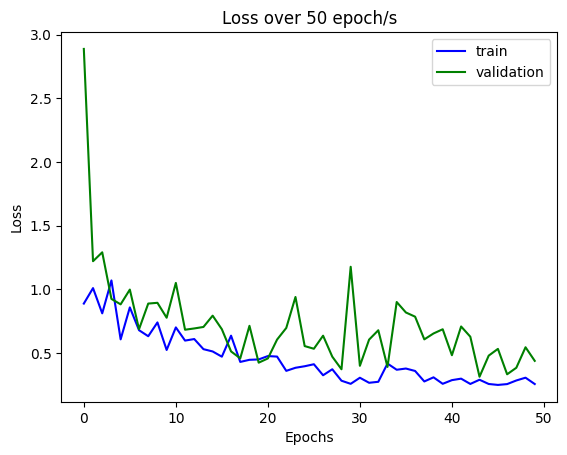

In [ ]:
plot_losses(MODEL_PATH)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]


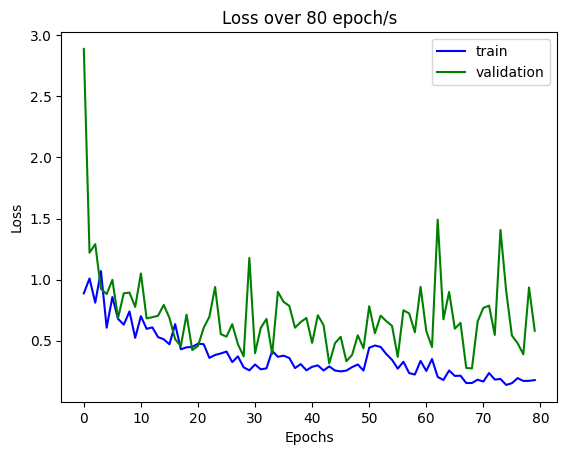

In [ ]:
plot_losses(MODEL_PATH)

In [ ]:
from PIL import Image
from torchvision import transforms
IMG_HEIGHT = 256
IMG_WIDTH = 256

def predict_single_image(img_path) :
    if torch.cuda.is_available():
        DEVICE = 'cuda:0'
        print('Running on the GPU')
    else:
        DEVICE = "cpu"
        print('Running on the CPU')
        print(DEVICE)

    transform = transforms.Compose([
            transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.NEAREST),
        ])

    image = Image.open(img_path)
    image = transforms.ToTensor()(image)
    image = image.unsqueeze(0)
    image = image.to(DEVICE)

    model = UNET(in_channels=3, classes=12).to(DEVICE).train()
    checkpoint = torch.load(f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/ckpt_save/unet.pth") #  'ckpt_save/unet')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    with torch.no_grad():
        output = model(image)
        output = torch.softmax(output, dim=1)
        pred = torch.argmax(output, dim=1)

    pred = pred.squeeze().cpu().numpy()


    # Visualize the result
    plt.imshow(pred)
    plt.show()

Running on the GPU


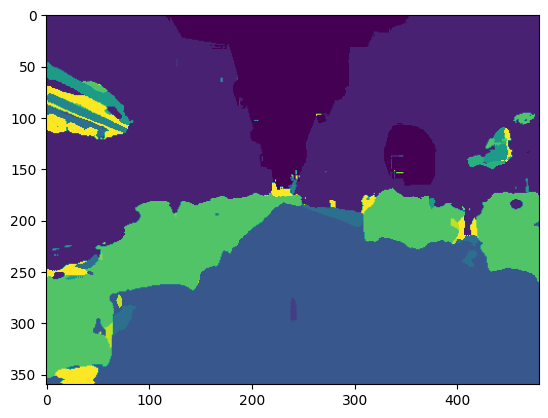

In [ ]:
predict_single_image(f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/datasets_used/train/images/0016E5_06330.png")

Running on the GPU


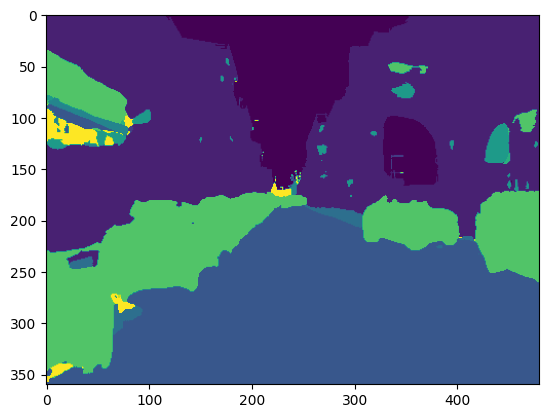

In [ ]:
predict_single_image(f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/datasets_used/train/images/0016E5_06330.png")

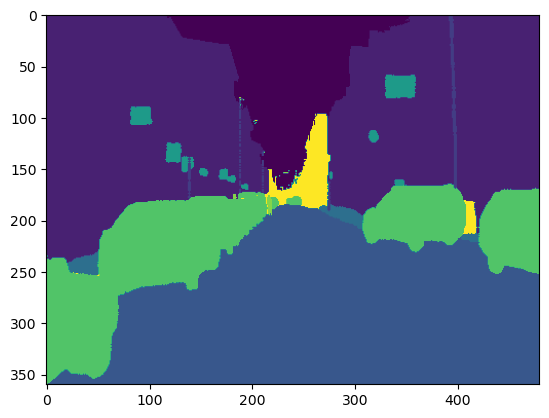

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
n= cv2.imread(f"datasets_used/train/masks/0016E5_06330.png",cv2.IMREAD_GRAYSCALE)
plt.imshow(n)

In [ ]:
if torch.cuda.is_available():
    DEVICE = 'cuda:0'
    print('Running on the GPU')
else:
    DEVICE = "cpu"
    print('Running on the CPU')
print(DEVICE)
unet = UNET(in_channels=3, classes=9).to(DEVICE).train()
unet.cuda()

Running on the GPU
cuda:0


UNET(
  (double_conv_downs): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(256, 256, kernel

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class UNET2(nn.Module):

    def __init__(self, in_channels=3, classes=1):
        super(UNET2, self).__init__()
        self.layers = [in_channels, 64, 128, 256, 512, 1024]

        self.double_conv_downs = nn.ModuleList(
            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])

        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])

        self.double_conv_ups = nn.ModuleList(
        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)


    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv

    def forward(self, x):
        # down layers
        concat_layers = []

        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)

        concat_layers = concat_layers[::-1]

        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])

            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)

        x = self.final_conv(x)

        return x

In [ ]:
model = UNET2(in_channels=3, classes=9)
model.cuda()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
